In [ ]:
import timeit
start = timeit.default_timer()
from fenics import *
from dolfin 
import Matrix
import dolfin as dl

from sympy import DiracDelta
import sympy as sym
#
# To activate this environment, use
#

#
# To deactivate an active environment, use
#
#     $ 
import math
from numpy import linalg as LA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)


In [ ]:
LNWDT=4; FNT=14
plt.rcParams['lines.linewidth'] = LNWDT; plt.rcParams['font.size'] = FNT

In [ ]:
def true_model(prior):
    noise = dl.Vector()
    prior.init_vector(noise,"noise")
    parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

In [ ]:
ndim, nx, ny = [2, 50, 50]
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]

print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )

prVar, prRange = [1, 2.]

delta1 = np.sqrt(0.125*(6.3**2)/(prRange**2 * prVar**2))
gamma = 0.125/(delta1* prVar**2)
print('gamma = ', gamma)

print('delta1 = ', delta1)

#np.savetxt('basicparameter.txt', np.array([ndim, nx, ny, gamma, delta1]), fmt="%.3f", header="ndim nx  ny gamma delta1")

In [ ]:
#u = dl.TrialFunction(Vh[STATE])
#v = dl.TestFunction(Vh[STATE])

p_trial = dl.TrialFunction(Vh[ADJOINT])
p_test = dl.TestFunction(Vh[ADJOINT])

trial = dl.TrialFunction(Vh[PARAMETER])
test  = dl.TestFunction(Vh[PARAMETER])
varfM = dl.inner(trial,test)*dl.dx

def sqrt_precision_varf_handler(trial, test): 
        #if Theta == None:
        varfL = dl.inner(dl.grad(trial), dl.grad(test))*dl.dx
        #else:
           # varfL = dl.inner( Theta*dl.grad(trial), dl.grad(test))*dl.dx
        varfM = dl.inner(trial,test)*dl.dx

        varf_robin = dl.inner(trial,test)*dl.ds
        #if robin_bc:
        robin_coeff = gamma*np.sqrt(delta1/gamma)/1.42
        #else:
        #robin_coeff = 0.
        return (dl.Constant(gamma)*varfL + dl.Constant(delta1)*varfM + dl.Constant(robin_coeff)*varf_robin)

M = dl.assemble(varfM)
Kmat = dl.assemble(sqrt_precision_varf_handler(trial, test))
KmatInv = LA.inv(Kmat.array())

CC = np.matmul(np.matmul(KmatInv, M.array()), np.transpose(KmatInv))
#print(LA.eigvals(CC))

Minv = LA.pinv(M.array())
#np.savetxt('Priorma.txt', np.array(CC), header="CC")
#CC = np.loadtxt('Priorma.txt') 
#np.savetxt('Massma.txt', np.array(Minv), header="Minv")

In [ ]:
# Define boundary subdomains
tol = 1e-14
class BoundaryX0(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dl.near(x[0], 0, tol)

class BoundaryX1(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dl.near(x[0], 1, tol)

class BoundaryY0(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dl.near(x[1], 0, tol)

class BoundaryY1(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dl.near(x[1], 1, tol)
    
# Initialize sub-domain instances    

# Initialize mesh function for boundary domains and Mark boundaries
boundary_markers = dl.MeshFunction('size_t', mesh, 1)
boundary_markers.set_all(9999)

bx0 = BoundaryX0()
bx1 = BoundaryX1()
by0 = BoundaryY0()
by1 = BoundaryY1()

bx0.mark(boundary_markers, 0)
bx1.mark(boundary_markers, 1)
by0.mark(boundary_markers, 2)
by1.mark(boundary_markers, 3)
    
# Redefine boundary integration measure
dl.ds = dl.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

g_00 = dl.Constant(0.0)
g_0 = dl.Expression('0.7*x[1]', degree=1)   #Neuman data
#r0 = 0                                      #Robain data

boundary_conditions = {0: {'Neumann': g_00},   # x = 0
                       1: {'Neumann': g_00},   # x = 1
                       2: {'Dirichlet': g_00}, # y = 0
                       3: {'Neumann':   g_0}}      # y = 1

bcs = []
for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        bc = dl.DirichletBC(Vh[STATE], boundary_conditions[i]['Dirichlet'],
                         boundary_markers, i)
        bcs.append(bc)

In [ ]:
boundary_conditions_adj = {0: {'Neumann': dl.Constant(0.0)},   # x = 0
                       1: {'Neumann': dl.Constant(0.0)},   # x = 1
                       2: {'Dirichlet': dl.Constant(0.0)}, # y = 0
                       3: {'Neumann':   dl.Constant(0.0)}}      # y = 1

# Collect Dirichlet conditions
bcs_adj = []
for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        bc = dl.DirichletBC(Vh[ADJOINT], boundary_conditions_adj[i]['Dirichlet'],
                         boundary_markers, i)
        bcs_adj.append(bc)

In [ ]:
#f = dl.Constant(2.0)
f = dl.Constant(0.0)

gmax=2.
gmin1=-2.
gmin2=0.0  # was 0.0
alpha=0.5
beta=4

#def g1(g):
#    arg = 0.5*(gmax-gmin1)*( np.tanh(beta*(g+alpha))-1.)+ 0.5*(gmax-gmin2)*( np.tanh(beta*(alpha-g))-1.)+gmax
#    z0 = g.copy()
#    z0.set_local(arg)
#    return z0

def g1(g):
    arg =  np.tanh(beta*(g+alpha))+np.tanh(beta*(g-alpha))
    z0 = g.copy()
    z0.set_local(arg)
    return z0



def fun1(x):
    return (dl.exp(x)-dl.exp(-x))/(dl.exp(x)+dl.exp(-x))

#def Tanfun(m):
#    term1 = dl.Constant(0.5)*dl.Constant(gmax-gmin1)*( fun1(beta*(m+alpha))-dl.Constant(1.))
#    term2 = dl.Constant(0.5)*dl.Constant(gmax-gmin2)*( fun1(beta*(alpha-m))-dl.Constant(1.))
#    return term1 + term2 + dl.Constant(gmax)

def Tanfun(m):
    term1 = fun1(beta*(m+alpha))
    term2 = fun1(beta*(m-alpha))
    return term1 + term2 

#def derK(m):
#    term1 = fun1(beta*(m+alpha))*fun1(beta*(m+alpha))
#    term2 = fun1(beta*(alpha-m))*fun1(beta*(alpha-m))
#    return dl.exp(Tanfun(m))*beta*(dl.Constant(1.)-dl.Constant(0.5)*dl.Constant(gmax-gmin1)*term1+dl.Constant(0.5)*dl.Constant(gmax-gmin2)*term2)

def pde_varf(u,m,p):
    return dl.exp(Tanfun(m))*dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx-f*p*dl.dx-g_00*p*dl.ds(0)-g_00*p*dl.ds(1)-g_0*p*dl.ds(3)
    #return dl.exp(m)*dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx - f*p*dl.dx-g_00*p*dl.ds(0)-g_00*p*dl.ds(1)-g_0*p*dl.ds(3)

pde = PDEVariationalProblem(Vh, pde_varf, bc=bcs, bc0=bcs_adj, is_fwd_linear=True)

The true GRF:  <dolfin.cpp.la.Vector object at 0x7fdee84cd360>
The true log-perm:  <dolfin.cpp.la.Vector object at 0x7fdee84cd360>


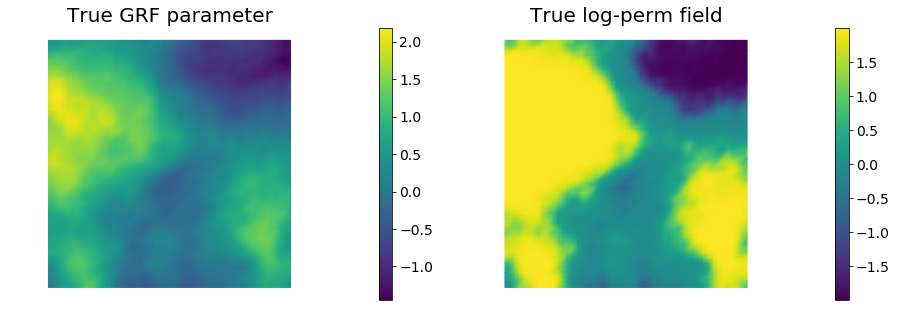

In [9]:
prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta1, robin_bc=True)
mtrue = true_model(prior)
print('The true GRF: ', mtrue)
plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], mtrue), subplot_loc=121, mytitle="True GRF parameter")

#generate the true log-perm field mtrue
# np.savetxt('Trueparameter.txt', np.array(mtrue.get_local()), header="mtrue")
#mtrue = np.loadtxt('Trueparameter.txt')

gtrue = g1(mtrue)
print('The true log-perm: ', mtrue)
#plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], gtrue), subplot_loc=122, mytitle="True log-perm field")
plt.show()

In [ ]:
ntargetsx = 5
ntargetsy = 5
rel_noise = 0.01  # was 0.01

targets_x = np.linspace(start=0.1,stop=0.9,num=ntargetsx)
targets_y = np.linspace(start=0.1,stop=0.9,num=ntargetsy)
targets = np.zeros([ntargetsx*ntargetsy, ndim])
targets[:,0] = np.kron(targets_x,np.ones(ntargetsy))
targets[:,1] = np.kron(np.ones(ntargetsx),targets_y)

print( "Number of observation points: {0}".format(np.shape(targets)[0]) )
misfit = PointwiseStateObservation(Vh[STATE], targets)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise 
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev
dobs = np.zeros([ntargetsx*ntargetsy, 1])
dobs[:,0] = misfit.d

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()


In [ ]:
plt.figure()
plt.imshow(M.array())
plt.colorbar()

plt.show()

In [ ]:
start = timeit.default_timer()
n1 = 1000   # was 4
n2 = 1  # was 5

k = 50
p = 20  # was 20

utrue2 = pde.generate_state()
x_pr = [utrue2, prior.mean, None]
pde.solveFwd(x_pr[STATE], x_pr)
                                       
all_prior = np.zeros((Vh[PARAMETER].dim(), n1))
all_real_x = np.zeros((Vh[PARAMETER].dim(), n1*n2))
all_star_x = np.zeros((Vh[PARAMETER].dim(), n1*n2))
all_wei_x = np.zeros(n1*n2)
all_wei1_x = np.zeros(n1*n2)
#all_wei2_x = np.zeros(n1*n2)
all_misfits = np.zeros(n1*n2)
all_misfits_p = np.zeros(n1)
all_misfits_d = np.zeros(n1)
all_reason = np.zeros(n1*n2)
dobp = np.zeros((ntargetsx*ntargetsy, n1))
s_a = np.zeros([ntargetsx*ntargetsy, n1*n2])

all_V_det = np.zeros(n1*n2)
all_V_det1 = np.zeros(n1*n2)
#all_V_det2 = np.zeros(n1*n2)
all_Joc_det = np.zeros(n1*n2)

C_D =misfit.noise_variance*np.eye(ntargetsx*ntargetsy)

#print('misfit.d = ',np.reshape(misfit.d,(5,5)), '  (before loop)')

for j in range(n1):
    print('Start of loop ',j)
    # Create a sample from the prior for RML (call it gtrue1)
    prior1 = BiLaplacianPrior(Vh[PARAMETER], gamma, delta1, robin_bc=True)
    mtrue1 = true_model(prior1)
    prior1.mean = mtrue1
    all_prior[:,j] = mtrue1.copy()
    
    # Create sample of data by perturbing the actual observations for the minimum
    parRandom.normal_perturb(noise_std_dev, misfit.d)
    dobp[:,j] = misfit.d
    #define the J function
    model = Model(pde, prior1, misfit)
    solver = ReducedSpaceNewtonCG(model)
    solver.parameters["max_iter"]      = 300
    
#To a same sample, compute multiple MAP points through different initial values
    for s in range(n2):
         #Create random initial model for minimization
        prior0 = BiLaplacianPrior(Vh[PARAMETER], gamma, delta1, robin_bc=True)
        m = true_model(prior1)
        #m0 = np.random.normal(size=Vh[PARAMETER].dim())
        #m = 0*prior.mean.copy()
        #m.set_local(m0)
        
        # Solve for RML minimizer
        x = solver.solve([None, m, None]) 
        #Termination reason:1 is the convergence when sqrt(g,g) <= abs_tolerance;2 is maximum number of iterations
        # 3 is the convergence when (g,dm) <= gdm_tolerance
        all_reason[j*n2+s] = solver.reason
        all_star_x[:,j*n2+s] = m.copy()
        
        posterior.mean = x[PARAMETER]
        all_real_x[:,j*n2+s] = posterior.mean
        
        # Output the simulated data from RML sample (call it s_a)
        ut1 = pde.generate_state()
        dpo = [ut1, posterior.mean, None]
        pde.solveFwd(dpo[STATE], dpo)
        misfit1 = PointwiseStateObservation(Vh[STATE], targets)
        
        misfit1.B.mult(dpo[STATE], misfit1.d)
        s_a[:,j*n2+s] = misfit1.d
        
        #print('s_a = ',np.reshape(s_a,(5,5)))
        #print('dobs = ',np.reshape(dobs,(5,5)))

        #compute the weights of RML samples
        
        # Compute the low-rank eigenvalue/eigenvector decomposition
        model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
        Hmisfit = ReducedHessian(model, misfit_only=True)
        
        Omega = MultiVector(x[PARAMETER], k+p)
        parRandom.normal(1., Omega)
        lmbda, V = doublePassG(Hmisfit, prior.R, prior.Rsolver, Omega, k)
        lm_index0 = np.argwhere(lmbda>1e-120)
        lmbda = lmbda[lm_index0]
        Joc_det = (np.prod(1+lmbda))**(-1)
        V_det = np.prod(1+lmbda)
                
#         #compute the gradient with respect to MAP point
        #set the deriction h of Gateaux derivative by randomly generated
#         h = model.generate_vector(PARAMETER)
#         parRandom.normal(1., h)
        h = posterior.mean-prior.mean
        G = np.zeros((ntargetsx*ntargetsy,Vh[PARAMETER].dim()))
        G_po = np.zeros((ntargetsx*ntargetsy,1))
        G_po1 = np.zeros((ntargetsx*ntargetsy,1))
    
        s_a0 = np.zeros((ntargetsx*ntargetsy,1))
        s_a0[:,0] = s_a[:,j*n2+s]
        dc1 = s_a0-dobs
#         print(dc1)
        for l in range(ntargetsx*ntargetsy):
            
            L = dl.Constant(0)*p_test*dl.dx

            mFun = dl.Function(Vh[PARAMETER])
            mFun.vector().set_local(all_real_x[:,j*n2+s])

            a_adj = dl.inner(dl.exp(Tanfun(mFun))*dl.nabla_grad(p_trial), dl.nabla_grad(p_test)) * dl.dx
            #a_adj = dl.inner(dl.exp(mFun)*dl.nabla_grad(p_trial), dl.nabla_grad(p_test)) * dl.dx
            adjoint_A, adj_rhs = dl.assemble_system(a_adj, L, bcs_adj)

            deltaS = dl.PointSource(Vh[ADJOINT], dl.Point(targets[l,0], targets[l,1]), 0.000385)

            deltaS.apply(adj_rhs)
                     
            p_1 = model.generate_vector(ADJOINT)
            x_pp = [dpo[STATE], posterior.mean, p_1]
            #solve the adjoint equation
            pde.solveAdj(x_pp[ADJOINT], x_pp, -adj_rhs)

            grad1 = model.generate_vector(PARAMETER)
            model.evalGradientParameter([dpo[STATE], posterior.mean, x_pp[ADJOINT]], grad1, misfit_only=True)
            
            grad0 = np.matmul(grad1,Minv)
            G[l,:] = grad0.copy()
            
            mtilde_grad0 = np.matmul(grad0,h)
            G_po[l,0] = mtilde_grad0
            
            uFun = dl.Function(Vh[STATE], dpo[STATE])
            pFun = dl.Function(Vh[ADJOINT], x_pp[ADJOINT])
            # define Test Functions
            u_test, m_test, p_test1 = dl.TestFunction(Vh2), dl.TestFunction(Vh1),dl.TestFunction(Vh2)
            # weak form for gradient
#             CTvarf = dl.inner(dl.exp(mFun)*m_test*dl.grad(uFun), dl.grad(pFun)) * dl.dx
#            CTvarf = dl.inner(derK(mFun)*m_test*dl.grad(uFun), dl.grad(pFun)) * dl.dx
#             CTvarf = dl.inner(dl.exp(Tanfun(mFun))*m_test*dl.grad(uFun), dl.grad(pFun)) * dl.dx
            
#            gr = dl.assemble(CTvarf)
#            gr0 = np.matmul(gr,Minv)
#            gr1 = np.matmul(gr0,h)
#            G_po1[l,0] = gr1
        
        C_D =misfit.noise_variance*np.eye(ntargetsx*ntargetsy)
        eta_x = G_po-(s_a0-dobs)
        
        V_x = C_D + np.matmul(np.matmul(G, CC),G.transpose())
        V_det1 = LA.det(V_x/(misfit.noise_variance)) #/misfit.noise_variance**(ntargetsx*ntargetsy)
#        V_x1 = 3.1*C_D + np.matmul(np.matmul(G, CC),G.transpose())
#        V_det2 = LA.det(V_x1/(3.1*misfit.noise_variance)) #/misfit.noise_variance**(ntargetsx*ntargetsy)
        
        all_V_det[j*n2+s] = V_det
        all_V_det1[j*n2+s] = V_det1
        all_Joc_det[j*n2+s] = Joc_det

#         print('V_det = ',V_det)
#         print('V_det1 = ',V_det1)
        
        C_xGTG = np.matmul(CC,np.matmul(G.transpose(),G))/misfit.noise_variance
        C_xeig =np.array(LA.eigvals(C_xGTG)).real
        
        #Joc_det = misfit.noise_variance**(ntargetsx*ntargetsy)*(V_det1**(-1))
        logG = np.matmul(np.matmul(eta_x.transpose(), LA.pinv(V_x)), eta_x)

        #print(Joc_det)
#        all_wei1_x[j*n2+s] = V_det**(-0.5)*np.exp(-(1/2.)*logG)
        all_wei1_x[j*n2+s] = V_det1**(0.5)* np.exp(-(1/2.)*logG)/Joc_det
        all_wei_x[j*n2+s] = V_det1**(-0.5)*np.exp(-(1/2.)*logG)

        all_misfits[j*n2+s] = np.dot((s_a0-dobs).T,(s_a0-dobs))
     
    dobp0 = np.zeros((ntargetsx*ntargetsy,1))
    dobp0[:,0] = dobp[:,j]
    all_misfits_p[j] = np.matmul(np.matmul((all_prior[:,j] - prior.mean.copy()).T, LA.inv(CC)), all_prior[:,j] - prior.mean.copy())
    all_misfits_d[j] = np.matmul(np.matmul((dobs - dobp0).T, LA.inv(C_D)), dobs - dobp0)
    misfit.d.set_local(dobs)   
# print(all_wei_x)
print(all_reason)

stop = timeit.default_timer()
print('Time: ', stop - start)


In [ ]:
print('max G[24] =', np.max(G[24]))
print('min G[24] =', np.min(G[24]))
print(np.shape(G[24]))

print('max G_po =', np.max(G_po))
print('min G_po =', np.min(G_po))
print(np.shape(G_po))


In [ ]:
# # # #save data
# np.savetxt('Trueparameter2T1e3.txt', np.array(mtrue.get_local()), header="mtrue")
# np.savetxt('Trueobs2T1e3.txt', np.array(dobs), header="Observation")
# np.savetxt('Priordata2T1e3.txt', np.array(all_prior), header="all_prior")
# np.savetxt('Posteriordata2T1e3.txt', np.array(all_real_x), header="all_real_x")
# np.savetxt('Startdata2T1e3.txt', np.array(all_star_x), header="all_star_x")
# np.savetxt('Weightdata2T1e3.txt', np.array(all_wei_x), header="all_wei_x")
# np.savetxt('Weightdata2T1e3_1.txt', np.array(all_wei1_x), header="all_wei1_x")
# # np.savetxt('WeightdataT1e3_23.txt', np.array(all_wei2_x), header="all_wei2_x")
# np.savetxt('Misfitsdata2T1e3.txt', np.array(all_misfits), header="all_misfits")
# np.savetxt('Misfitspdata2T1e3.txt', np.array(all_misfits_p), header="all_misfits_p")
# np.savetxt('Misfitsddata2T1e3.txt', np.array(all_misfits_d), header="all_misfits_d")
# np.savetxt('Reasondata2T1e3.txt', np.array(all_reason), header="all_reason")
# np.savetxt('Obserdata2T1e3_3.txt', np.array(dobp), header="dobp")
# np.savetxt('Statedata2T1e3_3.txt', np.array(s_a), header="s_a")
# np.savetxt('JocdataT1e3_3.txt', np.array(all_Joc_det), header="all_Joc_det")
# np.savetxt('lowVdataT1e3_3.txt', np.array(all_V_det), header="all_V_det")
# np.savetxt('higVdataT1e3_3.txt', np.array(all_V_det1), header="all_V_det1")
# np.savetxt('higVdataT1e3_13.txt', np.array(all_V_det1), header="all_V_det2")

# # all_prior = np.loadtxt('PriordataT1e3_1.txt')
# # all_real_x = np.loadtxt('PosteriordataT1e3_1.txt')
# # # all_star_x = np.loadtxt('Startdata.txt')
# # all_wei_x = np.loadtxt('WeightdataT1e3_1.txt')
# # all_misfits = np.loadtxt('MisfitsdataT1e3_1.txt')
# # # all_misfits_p = np.loadtxt('Misfitspdata.txt')
# # # all_misfits_d = np.loadtxt('Misfitsddata.txt')
# # all_reason = np.loadtxt('ReasondataT1e3_1.txt')
# # # dobp = np.loadtxt('Reasondata.txt')
# # # s_a = np.loadtxt('Statedata.txt')
# # # all_Joc_det = np.loadtxt('Jocdata.txt')
# # # all_V_det = np.loadtxt('lowVdata.txt')
# # # all_V_det1 = np.loadtxt('higVdata.txt')
# # dobs = np.loadtxt('TrueobsT1e3_1.txt')


In [ ]:
#Plot the sensitivity
plt.figure()
nb.plot(dl.Function(Vh[PARAMETER], grad1), mytitle="G[24]")
plt.show()
#plt.savefig('Gradient_wo_transform_obs24_HL_code.png')

In [ ]:
plt.figure()
plt.semilogy(lmbda[0:22], label='lamda by low-rank')
plt.semilogy(C_xeig[0:22], label='lamda by C_xG^TC_D^{-1}G')
#plt.ylim( (10**-2,10**4) )
plt.title('sD = '+ str(rel_noise))
plt.legend()

plt.show()
#plt.savefig('eigenvalues_lambda_wTrans_sD0pt01.png')

In [ ]:
all_wei_x1 = all_wei_x/np.sum(all_wei_x)
# all_wei1_x1 = all_wei1_x1/np.sum(all_wei1_x1)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].semilogy(all_misfits, all_wei_x1,'o', alpha=0.5)
axs[0].set_title('weights vs misfit')
axs[0].set_xlabel('squared misfit')
axs[0].set_ylabel('weights')

axs[1].semilogy(all_misfits, all_wei_x1,'o', alpha=0.5)
axs[1].set_title('weights vs misfit')
axs[1].set_xlabel('squared misfit')
axs[1].set_ylabel('weights')
axs[1].set_xlim(0,0.006)
axs[1].set_ylim( (10.**-8,10.**0) )
plt.tight_layout()
plt.show()

In [ ]:
#for i in range(np.shape(all_wei_x)[0])

for i in range(np.shape(all_wei_x)[0]):
    if all_misfits[i] <= 0.003:
        print(i, " ", all_misfits[i], " ",all_wei_x[i])

In [ ]:
pr_sample = dl.Function(Vh[PARAMETER]).vector()

plt.figure(figsize=(15,5))
pr_sample.set_local(all_real_x[:,51])
#the sample with the largest weight
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=121,mytitle="Posterior1 (RML)")
pr_sample.set_local(all_real_x[:,27])
#the sample with the second largest weight
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=122,mytitle="Posterior2 (RML)")
plt.show()

#plt.savefig('compare_two_low_misfit.pdf')


In [ ]:
# # #save data
# np.savetxt('Trueparameter1T1e3.txt', np.array(mtrue.get_local()), header="mtrue")
# np.savetxt('Trueobs1T1e3.txt', np.array(dobs), header="Observation")
# np.savetxt('Priordata1T1e3.txt', np.array(all_prior), header="all_prior")
# np.savetxt('Posteriordata1T1e3.txt', np.array(all_real_x), header="all_real_x")
# np.savetxt('Startdata1T1e3.txt', np.array(all_star_x), header="all_star_x")
# np.savetxt('Weightdata1T1e3.txt', np.array(all_wei_x), header="all_wei_x")
# np.savetxt('Weightdata1T1e3_1.txt', np.array(all_wei1_x), header="all_wei1_x")
# np.savetxt('Weightdata1T1e3_2.txt', np.array(all_wei2_x), header="all_wei2_x")
# np.savetxt('Misfitsdata1T1e3.txt', np.array(all_misfits), header="all_misfits")
# np.savetxt('Misfitspdata1T1e3.txt', np.array(all_misfits_p), header="all_misfits_p")
# np.savetxt('Misfitsddata1T1e3.txt', np.array(all_misfits_d), header="all_misfits_d")
# np.savetxt('Reasondata1T1e3.txt', np.array(all_reason), header="all_reason")
# np.savetxt('Obserdata1T1e3.txt', np.array(dobp), header="dobp")
# np.savetxt('Statedata1T1e3.txt', np.array(s_a), header="s_a")
# np.savetxt('Jocdata1T1e3.txt', np.array(all_Joc_det), header="all_Joc_det")
# np.savetxt('lowVdata1T1e3.txt', np.array(all_V_det), header="all_V_det")
# np.savetxt('higVdata1T1e3.txt', np.array(all_V_det1), header="all_V_det1")
# np.savetxt('higVdata1T1e3_1.txt', np.array(all_V_det1), header="all_V_det2")

# all_prior = np.loadtxt('PriordataT1e3_1.txt')
# all_real_x = np.loadtxt('PosteriordataT1e3_1.txt')
# # all_star_x = np.loadtxt('Startdata.txt')
# all_wei_x = np.loadtxt('WeightdataT1e3_1.txt')
# all_misfits = np.loadtxt('MisfitsdataT1e3_1.txt')
# # all_misfits_p = np.loadtxt('Misfitspdata.txt')
# # all_misfits_d = np.loadtxt('Misfitsddata.txt')
# all_reason = np.loadtxt('ReasondataT1e3_1.txt')
# # dobp = np.loadtxt('Reasondata.txt')
# # s_a = np.loadtxt('Statedata.txt')
# # all_Joc_det = np.loadtxt('Jocdata.txt')
# # all_V_det = np.loadtxt('lowVdata.txt')
# # all_V_det1 = np.loadtxt('higVdata.txt')
# dobs = np.loadtxt('TrueobsT1e3_1.txt')

#all_wei_x = np.loadtxt('WeightdataT1e3_1.txt')
#all_reason = np.loadtxt('ReasondataT1e3_1.txt')
#all_misfits = np.loadtxt('MisfitsdataT1e3_1.txt')
#all_V_det = np.loadtxt('lowVdataT1e3_1.txt')
#all_V_det1 = np.loadtxt('higVdataT1e3_1.txt')


In [ ]:
#choose the samples of minimizers where the gradient norm achieves convergence 
re_index = np.argwhere(all_reason==1)
print(np.shape(re_index))
all_wei_x1 = all_wei_x[re_index]
all_wei1_x1 = all_wei1_x[re_index]
all_real_x1 = all_real_x[:,re_index[:,0]]
#print(np.shape(all_real_x1))
all_misfits1 = all_misfits[re_index]

print(np.shape(all_misfits1))
nReal_Roots = np.shape(all_real_x1)[1]
#print('number of real roots = ', nReal_Roots)

In [ ]:
all_wei1_x1 = all_wei1_x1/np.sum(all_wei1_x1)
# all_wei1_x1 = all_wei1_x1/np.sum(all_wei1_x1)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].semilogy(all_misfits1, all_wei1_x1,'o', alpha=0.5)
axs[0].set_title('weights vs misfit')
axs[0].set_xlabel('squared misfit')
axs[0].set_ylabel('weights')

#plt.show()
#plt.savefig('weights_vs_misfit-onlyV_wTrans.png')
axs[1].semilogy(all_misfits1, all_wei1_x1,'o', alpha=0.5)
axs[1].set_title('weights vs misfit')
axs[1].set_xlabel('squared misfit')
axs[1].set_ylabel('weights')
axs[1].set_xlim(0,0.006)
axs[1].set_ylim( (10**-9,10**0) )
plt.tight_layout()
plt.show()
#plt.savefig('weights_vs_misfit_all.png')


In [ ]:
all_wei_x1 = all_wei_x1/np.sum(all_wei_x1)
# all_wei1_x1 = all_wei1_x1/np.sum(all_wei1_x1)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].semilogy(all_misfits1, all_wei_x1,'o', alpha=0.5)
#axs[0].set_title('weights vs misfit')
axs[0].set_xlabel('squared misfit')
axs[0].set_ylabel('weights')

#plt.show()
#plt.savefig('weights_vs_misfit-onlyV_wTrans.png')
axs[1].semilogy(all_misfits1, all_wei_x1,'o', alpha=0.5)
#axs[1].set_title('weights vs misfit')
axs[1].set_xlabel('squared misfit')
axs[1].set_ylabel('weights')
axs[1].set_xlim(0,0.006)
axs[1].set_ylim( (10**-6,10**0) )
#plt.show()
plt.tight_layout()
plt.savefig('Case3_weights_vs_misfit_all_n1_400.pdf')


In [ ]:
ig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].semilogy(all_misfits1, all_V_det[all_reason==1]**(0.5),'o', alpha=0.5)
axs[0].set_title('V_det1 vs misfit')
axs[0].set_xlabel('squared misfit')
axs[0].set_ylabel('V_det1')

#plt.show()
#plt.savefig('weights_vs_misfit-onlyV_wTrans.png')
axs[1].semilogy(all_misfits1, all_V_det1[all_reason==1]**(0.5),'o', alpha=0.5)
axs[1].set_title('V_det vs misfit')
axs[1].set_xlabel('squared misfit')
axs[1].set_ylabel('V_det')
#axs[1].set_xlim(0,0.006)
#axs[1].set_ylim( (10**-9,10**0) )

plt.show()

In [ ]:
ig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].semilogy(all_misfits1, all_V_det[all_reason==1]**(0.5),'o', alpha=0.5)
axs[0].set_title('V_det1 vs misfit')
axs[0].set_xlabel('squared misfit')
axs[0].set_ylabel('V_det1')
axs[0].set_xlim(0,0.006)
axs[0].set_ylim( 10**9,10**19 )


#plt.show()
#plt.savefig('weights_vs_misfit-onlyV_wTrans.png')
axs[1].semilogy(all_misfits1, all_V_det1[all_reason==1]**(0.5),'o', alpha=0.5)
axs[1].set_title('V_det vs misfit')
axs[1].set_xlabel('squared misfit')
axs[1].set_ylabel('V_det')
axs[1].set_xlim(0,0.006)
axs[1].set_ylim( 10**6,10**14.5 )

plt.show()

In [ ]:
low_index = np.argwhere(all_misfits1<0.0035)
all_wei_x_low = all_wei_x1[low_index]

omegaSum = np.sum(np.array(all_wei_x_low))
omegaSum2 = np.sum(np.array(all_wei_x_low)**2)
nEff_low = (omegaSum**2)/omegaSum2

print(nEff_low)

In [ ]:
plt.loglog(all_V_det[re_index],all_V_det1[re_index],'o')
plt.show()

In [ ]:
np.sum(all_misfits1<0.1)

In [ ]:
# Compute effective sample size

omegaSum = np.sum(np.array(all_wei_x1))
omegaSum2 = np.sum(np.array(all_wei_x1)**2)
nEff = (omegaSum**2)/omegaSum2

print('effective sample size = ', nEff)

In [ ]:
# Compute effective sample size

omegaSum = np.sum(np.array(all_wei1_x1))
omegaSum2 = np.sum(np.array(all_wei1_x1)**2)
nEff = (omegaSum**2)/omegaSum2

print('effective sample size = ', nEff)

In [ ]:
#plot the histograms of the values of mand g1(m) at a few specified locations
parasx = 3
parasy = 3
para_x = np.linspace(start=0.1,stop=0.9,num=parasx)
para_y = np.linspace(start=0.1,stop=0.9,num=parasy)
paras = np.zeros([parasx*parasy, ndim])
paras[:,0] = np.kron(para_x,np.ones(parasy))
paras[:,1] = np.kron(np.ones(parasx),para_y)

#generate the specified locations for the permeability field
print( "Number of specified locations: {0}".format(np.shape(paras)[0]) )
paramisfit = PointwiseStateObservation(Vh[PARAMETER], paras)

#just use the minimizers
all_real_xm = all_real_x1
all_wei_xm = all_wei_x1

all_wei_xm1 = all_wei_xm/np.sum(all_wei_xm)
print(np.sum(all_wei_xm1))

#The true value of m and g1(m) at the specified locations
mstr = np.zeros([parasx*parasy, 1])
g1mstr = np.zeros([parasx*parasy, 1])
paramisfit.B.mult(mtrue, paramisfit.d)
mstr[:,0] = paramisfit.d
paramisfit.B.mult(gtrue, paramisfit.d)
g1mstr[:,0] = paramisfit.d

#generate the samples of the parameter with transformation at the specified locations
ms = np.zeros([parasx*parasy, np.shape(all_real_xm)[1]])
g1ms = np.zeros([parasx*parasy, np.shape(all_real_xm)[1]])
for i in range(np.shape(all_real_xm)[1]):
    m_sample=dl.Function(Vh[PARAMETER]).vector()
    m_sample.set_local(all_real_xm[:,i]) 
    paramisfit.B.mult(m_sample, paramisfit.d)
    ms[:,i] = paramisfit.d
    paramisfit.B.mult(g1(m_sample), paramisfit.d)
    g1ms[:,i] = paramisfit.d

#plot the last true sample and the specified locations
plt.figure(figsize=(15,5))
#nb.plot(dl.Function(Vh[PARAMETER], mtrue), mytitle="True log prameter", subplot_loc=131)
nb.plot(dl.Function(Vh[PARAMETER], gtrue), mytitle="True log prameter with_trans", subplot_loc=121)
nb.plot_pts(paras, paramisfit.d, mytitle="Parameter at specified locations", subplot_loc=122)
plt.show()

In [ ]:
#print(all_wei_xm1)
print(mstr[1])
print(mstr[3])
print(mstr[8])
we_index0 = np.argwhere(all_wei_xm1>1e-9)
we_index1 = np.argwhere(all_wei_xm1<=1e-9)
we_index0 = we_index0[:,0]
we_index1 = we_index1[:,0]

#plot the unweighted histograms of the values of m by sorting in two group (weighted >1e-9 and <1e-9) at the specified locations
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(ms[1,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[0].hist(ms[1,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[0].plot(mstr[1],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[0].set_title('m in '+ str(paras[1,:]))

axs[1].hist(ms[3,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[1].hist(ms[3,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[1].plot(mstr[3],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[1].set_title('m in '+ str(paras[3,:]))

axs[2].hist(ms[8,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[2].hist(ms[8,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[2].plot(mstr[8],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[2].set_title('m in '+ str(paras[8,:]))
# axs[2].set_title('C_D=20e-4')
axs[2].legend();
   
plt.show()

In [ ]:
#plot the unweighted histograms of the values of g1(m) by sorting in two group (weighted >1e-9 and <1e-9) at the specified locations
print(g1mstr[1])
print(g1mstr[3])
print(g1mstr[8])
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(g1ms[1,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[0].hist(g1ms[1,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[0].plot(g1mstr[1],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[0].set_title('logk in '+ str(paras[1,:]))

axs[1].hist(g1ms[3,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[1].hist(g1ms[3,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[1].plot(g1mstr[3],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[1].set_title('logk in '+ str(paras[3,:]))

axs[2].hist(g1ms[8,we_index0],15, density=1, alpha=0.5, color='b', label='w>1e-9')
axs[2].hist(g1ms[8,we_index1],15, density=1, alpha=0.5, color='g', label='w<1e-9')
#the true value of m
axs[2].plot(g1mstr[8],0, c='r', marker='*', markersize=10, label='True')
#the specified locations
axs[2].set_title('logk in '+ str(paras[8,:]))
axs[2].legend();
   
plt.show()

In [ ]:
#plot the weighted histograms of the values of m at the specified locations
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(ms[1,:],20, density=1, alpha=0.5, color='b', weights=all_wei_xm1)
 #the true value of m
axs[0].plot(mstr[1],0,c='r',marker='*', markersize=10)
#the specified locations
axs[0].set_xlim([-2,2.5])
# axs[0].set_title('m in '+ str(paras[1,:]))

axs[1].hist(ms[3,:],20, density=1, alpha=0.5, color='b', weights=all_wei_xm1)
 #the true value of m
axs[1].plot(mstr[3],0,c='r',marker='*', markersize=10)
#the specified locations
axs[1].set_xlim([-1,1.2])
# axs[1].set_title('m in '+ str(paras[3,:]))

axs[2].hist(ms[8,:],40, density=1, alpha=0.5, color='b', weights=all_wei_xm1, label='WeRML')
 #the true value of m
axs[2].plot(mstr[8],0,c='r',marker='*', markersize=10, label='True')
#the specified locations
axs[2].set_xlim([-2.2,0])
# axs[2].set_title('C_D=3.1e-4')
# axs[2].set_title('m in '+ str(paras[8,:]))
axs[2].legend();
   
plt.show()
# plt.savefig('histogram_weights.png')

In [ ]:
#plot the weighted histograms of the values of g1(m) at the specified locations
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(g1ms[1,:],30, density=1, alpha=0.5, color='b', weights=all_wei_xm1)
 #the true value of m
axs[0].plot(g1mstr[1],0,c='r',marker='*', markersize=10)
#the specified locations
axs[0].set_xlim([-2,2])
axs[0].set_title('logk in '+ str(paras[1,:]))

axs[1].hist(g1ms[3,:],30, density=1, alpha=0.5, color='b', weights=all_wei_xm1)
 #the true value of m
axs[1].plot(g1mstr[3],0,c='r',marker='*', markersize=10)
#the specified locations
axs[1].set_xlim([-2,2])
axs[1].set_title('logk in '+ str(paras[3,:]))

axs[2].hist(g1ms[8,:],30, density=1, alpha=0.5, color='b', weights=all_wei_xm1, label='weighted RML')
 #the true value of m
axs[2].plot(g1mstr[8],0,c='r',marker='*', markersize=10, label='True')
#the specified locations
axs[2].set_xlim([-3,3])
axs[2].set_title('logk in '+ str(paras[8,:]))
axs[2].legend();
   
plt.show()
plt.savefig('histogram_weights.png')

In [ ]:
## Unweighted mean
gg = np.zeros((Vh[PARAMETER].dim(),np.shape(all_real_x1)[1]))
for i in range(np.shape(all_real_x1)[1]):
    gg1 = 0*prior.mean.copy()
    gg1.set_local(all_real_x1[:,i])
    gg[:,i] = g1(gg1).get_local()
p_m = np.sum(gg,axis=1)/nReal_Roots
post_mean = 0*prior.mean.copy()
post_mean.set_local(p_m)

# Weighted mean
p_mwei = np.sum(gg*np.kron(np.ones((Vh[PARAMETER].dim(),1)), all_wei_x1.T), axis=1)
post_mean_wei = 0*prior.mean.copy()
post_mean_wei.set_local(p_mwei)

gg3 = np.zeros((Vh[PARAMETER].dim(),np.shape(all_real_x1)[1]))
for i in range(np.shape(all_real_x1)[1]):
    gg1 = 0*prior.mean.copy()
    gg1.set_local(all_prior[:,i])
    gg3[:,i] = g1(gg1).get_local()
p_rm = np.sum(gg3,axis=1)/nReal_Roots
prior_mean = 0*prior.mean.copy()
prior_mean.set_local(p_rm)


In [ ]:
plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], gtrue), subplot_loc=121,mytitle="True parameter")
# nb.plot(dl.Function(Vh[PARAMETER], g1(posterior.mean)), subplot_loc=122,mytitle="Posterior mean (SN)")
plt.show()

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], post_mean_wei), subplot_loc=122,mytitle="Posterior mean (WeRML)")
nb.plot(dl.Function(Vh[PARAMETER], post_mean), subplot_loc=121,mytitle="Posterior mean (RML)")
plt.show()

In [ ]:
x1=np.ones(nReal_Roots)
x1.shape=(nReal_Roots,1)

pr_pw_variance=(gg3-np.kron(x1,p_rm).transpose()).dot((gg3-np.kron(x1,p_rm).transpose()).transpose())
pr_pw_variance=np.diag(pr_pw_variance/nReal_Roots)

pr_w=dl.Function(Vh[PARAMETER]).vector()
pr_w.set_local(pr_pw_variance**0.5)

po_pw_variance=(gg-np.kron(x1,p_m).transpose()).dot((gg-np.kron(x1,p_m).transpose()).transpose())
po_pw_variance=np.diag(po_pw_variance/nReal_Roots)

po_w=dl.Function(Vh[PARAMETER]).vector()
po_w.set_local(po_pw_variance**0.5)

po_pw_variance_wei=(np.kron(np.ones((Vh[PARAMETER].dim(),1)), all_wei_x1.transpose())*(gg-np.kron(x1,p_mwei).transpose())).dot((gg-np.kron(x1,p_mwei).transpose()).transpose())
po_pw_variance_wei=np.diag(po_pw_variance_wei)

po_wei=dl.Function(Vh[PARAMETER]).vector()
po_wei.set_local(po_pw_variance_wei**0.5)


plt.figure()
nb.plot(dl.Function(Vh[PARAMETER], pr_w), mytitle="Prior sd")
plt.show()

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], po_w), subplot_loc=121,mytitle="Posterior sd(RML)")
nb.plot(dl.Function(Vh[PARAMETER], po_wei), subplot_loc=122,mytitle="Posterior sd(WeRML)")
plt.show()



In [ ]:
# #plot the histogram of the values of g1(m) in the whole physical domain by RML and WeRML
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].hist(gtrue.get_local(),30, density=1, alpha=0.5, color='b')
axs[0,0].set_title('True log-perm field')
axs[1,0].hist(post_mean.get_local(),30, density=1, alpha=0.5, color='b')
axs[1,0].set_title('RML')
axs[1,1].hist(post_mean_wei.get_local(),30, density=1, alpha=0.5, color='b')
axs[1,1].set_title('WeRML')

plt.show()

In [ ]:
plt.figure()
plt.loglog(all_V_det1, all_V_det, 'o', alpha=0.5)
plt.title('compare det V')
plt.xlabel('det V1')
plt.ylabel('det V')
#plt.xlim(0,0.01)
#plt.ylim( (10**-12,10**1) )
#plt.show()
plt.savefig('detV_vs_detV_all.png')

In [ ]:
plt.figure()
plt.loglog(all_V_det1, all_V_det, 'o', alpha=0.5)
plt.title('compare det V')
plt.xlabel('det V1')
plt.ylabel('det V')
plt.xlim(10.**20,10.**30)
plt.ylim( (10.**20,10.**30) )
#plt.show()
plt.savefig('detV_vs_detV.png')

In [ ]:
plt.semilogy(np.log10(all_V_det1), all_wei_x, 'o', alpha=0.5)
plt.title('weights vs log det V')
plt.xlabel('log det_v')
plt.ylabel('weights')
#plt.xlim(28.,31.)
#plt.ylim( (10.**-8,10.**1) )
plt.show()
#plt.savefig('weights_vs_detV_limit.png')

In [ ]:
plt.figure()
plt.hist(np.log10(all_wei_x1+10.**-250),30)
plt.show()
#plt.savefig('histogram_weights_all.png')

In [ ]:
plt.figure()
plt.hist(np.log10(all_wei_x1+10.**-120),200)
#plt.xlim(-7,0)
plt.show()
#plt.savefig('histogram_weights_limited.png')

In [ ]:
prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta1, robin_bc=True)
print(np.shape(all_real_x1))

## Unweighted mean
p_m = np.sum(all_real_x1,axis=1)/nReal_Roots
post_mean1 = 0*prior.mean.copy()
post_mean1.set_local(p_m)

# Weighted mean
p_mwei = np.sum(all_real_x1*np.kron(np.ones((Vh[PARAMETER].dim(),1)), all_wei_x1.T), axis=1)
post_mean_wei1 = 0*prior.mean.copy()
post_mean_wei1.set_local(p_mwei)

utrue0 = pde.generate_state()
x_pr = [utrue0, prior.mean, None]
pde.solveFwd(x_pr[STATE], x_pr)

utrue1 = pde.generate_state()
x_po_wei1 = [utrue1, post_mean1, None]
pde.solveFwd(x_po_wei1[STATE], x_po_wei1)

utrue2 = pde.generate_state()
x_po_wei2 = [utrue2, post_mean_wei1, None]
pde.solveFwd(x_po_wei2[STATE], x_po_wei2)

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], gtrue), subplot_loc=121,mytitle="True parameter")
nb.plot(dl.Function(Vh[STATE], utrue), subplot_loc=122,mytitle="True state")
plt.show()

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], g1(prior.mean)), subplot_loc=121,mytitle="Prior mean")
nb.plot(dl.Function(Vh[STATE], x_pr[STATE]), subplot_loc=122,mytitle="Prior state")
plt.show()

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], post_mean), subplot_loc=121,mytitle="Post_m (unweighted)")
nb.plot(dl.Function(Vh[STATE], x_po_wei1[STATE]), subplot_loc=122,mytitle="Post_u (unweighted)")
plt.show()

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], post_mean_wei), subplot_loc=121,mytitle="Post_m (weighted)")
nb.plot(dl.Function(Vh[STATE], x_po_wei2[STATE]), subplot_loc=122,mytitle="Post_u with (weighted)")
plt.show()


In [ ]:
#Find the first three largest weight samples by WeRML
wei =np.zeros(864)
wei[:]=all_wei_x1.T
# print(wei)
InD = np.argsort(wei)[-3:]
InD=InD[::-1]
ss=InD


## plot the three posterior samples and compare with posterior by Stochastic Newton for the correponding same prior
plt.figure(figsize=(20,5))
pr_sample = dl.Function(Vh[PARAMETER]).vector()
pr_sample.set_local(all_prior[:,ss[0]])
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=131,mytitle="Prior1")
pr_sample.set_local(all_prior[:,ss[1]])
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=132,mytitle="Prior2")
pr_sample.set_local(all_prior[:,ss[2]])
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=133,mytitle="Prior3")
plt.xlabel("Prior")
plt.show()


plt.figure(figsize=(20,5))
pr_sample.set_local(all_real_x1[:,ss[0]])
#the sample with the largest weight
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=131,mytitle="Posterior1 (RML)")
pr_sample.set_local(all_real_x1[:,ss[1]])
#the sample with the second largest weight
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=132,mytitle="Posterior2 (RML)")
pr_sample.set_local(all_real_x1[:,ss[2]])
#the sample with the third largest weight
nb.plot(dl.Function(Vh[PARAMETER], g1(pr_sample)), subplot_loc=133,mytitle="Posterior3 (RML)")
plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start) 

In [ ]:
4.*1000/(3.1416*135*135)

In [ ]:
0.06986208874371547*50

## Refine transformation

I would like to have three levels -- a low one for negative values of m, a high value for medium values of m, and an intermediate value for high values of m.

In [ ]:
def gX(g):
    arg = 0.5*(gmax-gmin1)*( np.tanh(beta*(g+alpha))-1.)+ 0.5*(gmax-gmin2)*( np.tanh(beta*(alpha-g))-1.)+gmax
    return arg

gmax=2.
gmin1=-2.
gmin2=-2.  # was 0.0
alpha=0.65
beta=4



def gX1(g):
    arg =  np.tanh(beta*(g+alpha))-1.
    return arg

def gX2(g):
    arg =  np.tanh(beta*(g-alpha))+1.
    return arg



In [ ]:
xPlot = np.arange(-2., 2., 0.05)

plt.figure()
plt.plot(xPlot,gX1(xPlot)+gX2(xPlot))
#plt.plot(xPlot,gX2(xPlot))

plt.xlabel('model parameter')
plt.ylabel('log-perm')
#plt.savefig('transform_to_logK.png')
plt.show()